In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import jax
jax.config.update("jax_enable_x64", True)

In [2]:
import jax.numpy as jnp
from jax import jit, grad, jacobian, lax, vmap

import numpy as np
import matplotlib.pyplot as plt

In [3]:
import time
import scipy.optimize as so

In [4]:
n = 3
dt = 1e-1
numsteps = 1000
rho = 1e6

h0 = np.load('workingh0.npz')['h0']
m = jnp.array([[1.0,1.5,-1.0],[1.5,1.0,0.0],[-1.0,0.0,1.0]])

# h0 = jnp.array(np.diag(np.sort(np.pi*np.random.uniform(size=n))))
# mraw = np.random.normal(size=n**2).reshape((n,n)) + 1j*np.random.normal(size=n**2).reshape((n,n))
# m = jnp.array(0.5*(mraw + mraw.conj().T))

print(jnp.mean(jnp.abs(h0 - h0.T)))
print(jnp.mean(jnp.abs(m - m.conj().T)))

0.0
0.0


In [5]:
# (d/dx) \exp(-1j*dt*(h0 + x m))
# where you pass in the eigenvectors and eigenvalues of (h0 + x m)
def firstderiv(evecs, evals):
    amat = evecs.conj().T @ (-1j*dt*m) @ evecs
    dvec = -1j*dt*evals
    dvec1, dvec2 = jnp.meshgrid(dvec, dvec)
    mask = jnp.ones((n,n)) - jnp.eye(n)
    numer = jnp.exp(dvec1) - jnp.exp(dvec2)
    denom = (dvec1 - dvec2)*mask + jnp.eye(n)
    derivmat = mask*numer/denom + jnp.diag(jnp.exp(dvec))
    qmat = evecs @ (amat * derivmat) @ evecs.conj().T
    return qmat

In [6]:
mask = jnp.ones((n,n)) - jnp.eye(n)

# (d^2/dx^2) \exp(-1j*dt*(h0 + x m))
# where you pass in the eigenvectors and eigenvalues of (h0 + x m)
def secondderiv(evecs, rawevals):
    evals = (-1j*dt)*rawevals
    a = (evecs.conj().T @ m @ evecs) * (-1j*dt)
    expevals = jnp.exp(evals)
    evals1, evals2 = jnp.meshgrid(evals, evals, indexing='ij')
    expevals1, expevals2 = jnp.meshgrid(expevals, expevals, indexing='ij')
    # first D_{ii}=D_{kk} term
    diagterm1 = expevals1*jnp.diag(jnp.diag(a*a))
    # second D_{ii}=D_{kk} term
    numer1 = -expevals1 + evals1*expevals1 - evals2*expevals1 + expevals2
    denom1 = (evals1-evals2)**2 + jnp.eye(n)
    maska = mask * a
    diagterm2 = jnp.eye(n) * 2*((numer1/denom1 * maska) @ maska)
    # first D_{ii}!=D_{kk} term
    frac1 = numer1/denom1 * mask
    term1 = frac1*2*(jnp.diag(a)*a).conj().T
    # second D_{ii}!=D_{kk} term
    numer2 = -expevals1 + evals1*expevals2 - evals2*expevals2 + expevals2
    denom2 = (evals1-evals2)**2 + jnp.eye(n)
    frac2 = numer2/denom2 * mask
    term2 = frac2*2*(a*jnp.diag(a))
    # third D_{ii}!=D_{kk} term
    matij = mask*(1.0/((evals1-evals2) + jnp.eye(n)))
    matind1a = (expevals1 * matij) * a
    matind2a = (expevals2 * matij) * a
    term3 = 2*mask*((matind2a) @ (matij*a))
    term3 -= 2*matij*( matind1a @ maska )
    term3 -= 2*matij*( maska @ matind2a ) 
    # put it all together
    # udagru stands for "U^{\dagger} R U"
    udagru = term1 - term2 - term3 + diagterm1 + diagterm2
    return evecs @ udagru @ evecs.conj().T

In [7]:
def gradal(l,expderiv,a,matexp):
    ea = expderiv @ a
    gradvecs = [(l==0)*ea + (l>0)*jnp.zeros(n, dtype=jnp.complex128)]
    for k in range(1,numsteps):
        thisvec = (k<l)*jnp.zeros(n, dtype=jnp.complex128)
        thisvec += (k==l)*ea
        thisvec += (k>l)*(matexp[k] @ gradvecs[k-1])
        gradvecs.append( thisvec )
    
    # zeroblock = jnp.zeros((l, n), dtype=jnp.complex128)
    return jnp.stack(gradvecs, axis=0)

In [8]:
def onehessrow(lamb,mu,ed,a,ga):
    part1 = jnp.real(mu @ ed @ a)
    part2 = jnp.real(lamb.T @ ed @ ga.T)
    return part1 + part2

In [9]:
def onematexp(evecs,expevals):
    return evecs @ jnp.diag(expevals) @ evecs.conj().T

In [10]:
manyeigh = vmap(jnp.linalg.eigh)
vfd = vmap(firstderiv, in_axes=(0,0))
vsd = vmap(secondderiv, in_axes=(0,0))
vgradal = vmap(gradal, in_axes=(0,0,0,None))
vohr = vmap(onehessrow)
vonematexp = vmap(onematexp)

In [11]:
# given initial condition and forcing f, return trajectory a
def propSchro(f, a0):
    manyhams = jnp.expand_dims(h0,0) + jnp.expand_dims(f,(1,2))*jnp.expand_dims(m,0)
    allevals, allevecs = manyeigh(manyhams)
    expevals = jnp.exp(-1j*dt*allevals)
    matexp = vonematexp(allevecs,expevals)
    
    a = jnp.concatenate([jnp.expand_dims(a0,0), jnp.zeros((numsteps, n), dtype=jnp.complex128)])
    def amatbody(k, am):
        return am.at[k+1].set( matexp[k] @ am[k] )
    
    # forward trajectory
    a = lax.fori_loop(0, numsteps, amatbody, a)
    return a

# given forcing f, IC a0, FC alpha, return cost
def cost(f, a0, alpha):
    a = propSchro(f, a0)
    resid = a[-1] - alpha
    pen = jnp.real(jnp.sum(resid * resid.conj()))
    return 0.5*jnp.sum(f**2) + 0.5*rho*pen

In [12]:
# adjoint method
def adjgrad(f, a0, alpha):
    manyhams = jnp.expand_dims(h0,0) + jnp.expand_dims(f,(1,2))*jnp.expand_dims(m,0)
    allevals, allevecs = manyeigh(manyhams)
    expevals = jnp.exp(-1j*dt*allevals)
    matexp = vonematexp(allevecs,expevals)
    
    a = jnp.concatenate([jnp.expand_dims(a0,0), jnp.zeros((numsteps, n), dtype=jnp.complex128)])
    def amatbody(k, am):
        return am.at[k+1].set( matexp[k] @ am[k] )
    
    # forward trajectory
    a = lax.fori_loop(0, numsteps, amatbody, a)
    
    # initialize lambda
    resid = a[-1] - alpha
    
    # we are storing "lambda conjugate" throughout this calculation
    alllamb = jnp.concatenate([jnp.expand_dims(rho*resid.conj(),0), jnp.zeros((numsteps, n), dtype=jnp.complex128)])
    def lambbody(i, al):
        k = (numsteps-1) - i
        return al.at[i+1].set( al[i] @ matexp[k] )
    
    # backward trajectory
    alllamb = lax.fori_loop(0, numsteps, lambbody, alllamb)
    alllamb = jnp.flipud(alllamb)
    
    # first critical calculation
    allexpderivs = vfd(allevecs, allevals)
    
    # output gradient we want
    ourgrad = jnp.einsum('ai,aij,aj->a',alllamb[1:],allexpderivs,a[:-1])
    thegrad = f + jnp.real(ourgrad)
    
    return thegrad

In [13]:
# second-order adjoint method
def adjhess(f, a0, alpha):
    manyhams = jnp.expand_dims(h0,0) + jnp.expand_dims(f,(1,2))*jnp.expand_dims(m,0)
    allevals, allevecs = manyeigh(manyhams)
    expevals = jnp.exp(-1j*dt*allevals)
    matexp = vonematexp(allevecs,expevals)

    a = jnp.concatenate([jnp.expand_dims(a0,0), jnp.zeros((numsteps, n), dtype=jnp.complex128)])
    def amatbody(k, am):
        return am.at[k+1].set( matexp[k] @ am[k] )
    
    # forward trajectory
    a = lax.fori_loop(0, numsteps, amatbody, a)
    
    # initialize lambda
    resid = a[-1] - alpha
    
    # we are storing "lambda conjugate" throughout this calculation
    alllamb = jnp.concatenate([jnp.expand_dims(rho*resid.conj(),0), jnp.zeros((numsteps, n), dtype=jnp.complex128)])
    def lambbody(i, al):
        k = (numsteps-1) - i
        return al.at[i+1].set( al[i] @ matexp[k] )
    
    # backward trajectory
    alllamb = lax.fori_loop(0, numsteps, lambbody, alllamb)
    alllamb = jnp.flipud(alllamb)
    
    # first critical calculation
    allexpderivs = vfd(allevecs, allevals)
    
    # compute gradient of a w.r.t. f
    # grada tensor stores the gradient of the n-dimensional vector a[k] with respect to f[l]
    lvec = jnp.arange(numsteps,dtype=jnp.int16)
    grada = vgradal(lvec, allexpderivs, a[:-1], matexp)
    grada = jnp.transpose(grada,(1,0,2))
     
    # create and propagate mu
    # as before, let us store and propagate "mu conjugate"
    allmu0 = rho*grada[numsteps-1,:,:].conj()
    allmu = jnp.concatenate([jnp.expand_dims(allmu0,0),
                             jnp.zeros((numsteps, numsteps, n), dtype=jnp.complex128)])
    allprevmu2 = jnp.flipud(jnp.outer(jnp.ones(n),jnp.eye(numsteps)).T.reshape((numsteps,numsteps,n)))
    def mubody(kk, amu):
        k = (numsteps-1) - kk
        prevmu1 = amu[kk] @ matexp[k]
        z = jnp.zeros((numsteps-1,n), dtype=jnp.complex128)
        prevmu2 = allprevmu2[kk] * jnp.expand_dims(alllamb[k+1].T @ allexpderivs[k],0)
        return amu.at[kk+1].set( prevmu1+prevmu2 )

    # backward trajectory
    allmu = lax.fori_loop(0, numsteps, mubody, allmu)
    allmu = jnp.flipud(allmu)
        
    # second critical calculation
    allexpderivs2 = vsd(allevecs, allevals)
    
    # compute Hessian
    gradapad = jnp.concatenate([jnp.zeros((1,numsteps,n),dtype=jnp.complex128), grada[:-1,:,:]])
    parts12 = vohr(alllamb[1:],allmu[1:],allexpderivs,a[:-1],gradapad)
    part3 = jnp.diag(jnp.real(jnp.einsum('ai,aij,aj->a',alllamb[1:],allexpderivs2,a[:-1])))
    thehess = jnp.eye(numsteps) + parts12 + part3
    
    return thehess

In [14]:
jcost = jit(cost)
jadjgrad = jit(adjgrad)
jadjhess = jit(adjhess)

In [15]:
mya0 = jnp.eye(n)[0]
# myalpha = jnp.array([jnp.sqrt(0.0),0,jnp.sqrt(1.0)])
myalpha = jnp.abs(jnp.array(np.random.normal(size=n)))
myalpha /= jnp.linalg.norm(myalpha)

In [16]:
ftest = jnp.array(np.random.normal(size=numsteps))
mycost = jcost(ftest, mya0, myalpha)
mygrad = jadjgrad(ftest, mya0, myalpha)
myhess = jadjhess(ftest, mya0, myalpha)

In [186]:
# gradcost = grad(cost)
# jgradcost = jit(gradcost)
# jaxgrad = jgradcost(ftest, mya0, myalpha)

# numruns = 100
# mytimes = np.zeros(numruns)
# jaxtimes = np.zeros(numruns)

# for j in range(numruns):
#     start = time.time()
#     myhess = jadjgrad(ftest, mya0, myalpha)
#     end = time.time()
#     mytimes[j] = end-start

# for j in range(numruns):
#     start = time.time()
#     myhess = jgradcost(ftest, mya0, myalpha)
#     end = time.time()
#     jaxtimes[j] = end-start

# print(np.mean(mytimes))
# print(np.mean(jaxtimes))
# print(np.mean(jaxtimes)/np.mean(mytimes))

# hesscost = jacobian(gradcost)
# jhesscost = jit(hesscost)
# jaxhess = jhesscost(ftest, mya0, myalpha)

# numruns = 100
# mytimes = np.zeros(numruns)
# jaxtimes = np.zeros(numruns)

# for j in range(numruns):
#     start = time.time()
#     myhess = jadjhess(ftest, mya0, myalpha)
#     end = time.time()
#     mytimes[j] = end-start

# for j in range(numruns):
#     start = time.time()
#     myhess = jhesscost(ftest, mya0, myalpha)
#     end = time.time()
#     jaxtimes[j] = end-start

# print(np.mean(mytimes))
# print(np.mean(jaxtimes))
# print(np.mean(jaxtimes)/np.mean(mytimes))

In [17]:
# # simple finite-difference gradient checker
# def fdgrad(kk, a0, alpha, myeps=1e-6):
#     pertvec = jnp.eye(numsteps)[kk]
#     cplus = cost( ftest + myeps*pertvec, a0, alpha )
#     cminus = cost( ftest - myeps*pertvec, a0, alpha )
#     return (cplus - cminus)/(2*myeps)

# # simple finite-difference gradient checker
# def fdhess(kk, a0, alpha, myeps=1e-6):
#     pertvec = jnp.eye(numsteps)[kk]
#     cplus = gradcost( ftest + myeps*pertvec, a0, alpha )
#     cminus = gradcost( ftest - myeps*pertvec, a0, alpha )
#     return (cplus - cminus)/(2*myeps)

# lvec = jnp.arange(numsteps)
# vfdgrad = vmap(fdgrad, in_axes=(0,None,None))
# myfdgrad = vfdgrad(lvec, mya0, myalpha)
# vfdhess = vmap(fdhess, in_axes=(0,None,None))
# myfdhess = vfdhess(lvec, mya0, myalpha)

In [18]:
def obj(x):
    jx = jnp.array(x)
    return jcost(jx,mya0,myalpha).item()

In [19]:
def gradobj(x):
    jx = jnp.array(x)
    return np.array(jadjgrad(jx,mya0,myalpha))

In [20]:
def hessobj(x):
    jx = jnp.array(x)
    return np.array(jadjhess(jx,mya0,myalpha))

In [21]:
xstar = so.minimize(obj, x0=ftest, method='trust-constr', jac=gradobj, hess=hessobj,
                    options={'gtol':1e-32,'xtol':1e-32,'verbose':2})

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +1.5618e+06 | 1.00e+00 | 2.02e+05 | 0.00e+00 |
|   2   |   2   |   1   | +1.4322e+06 | 1.00e+00 | 2.33e+05 | 0.00e+00 |
|   3   |   3   |   2   | +1.4322e+06 | 5.00e-01 | 2.33e+05 | 0.00e+00 |
|   4   |   4   |   3   | +1.1848e+05 | 1.00e+00 | 8.05e+04 | 0.00e+00 |
|   5   |   5   |   7   | +1.1848e+05 | 5.00e-01 | 8.05e+04 | 0.00e+00 |
|   6   |   6   |  11   | +6.1362e+04 | 5.00e-01 | 7.31e+04 | 0.00e+00 |
|   7   |   7   |  15   | +5.6573e+04 | 5.00e-01 | 6.43e+04 | 0.00e+00 |
|   8   |   8   |  20   | +5.0566e+04 | 5.00e-01 | 6.63e+04 | 0.00e+00 |
|   9   |   9   |  24   | +5.0566e+04 | 2.50e-01 | 6.63e+04 | 0.00e+00 |
|  10   |  10   |  28   | +9.0456e+03 | 5.00e-01 | 3.00e+04 | 0.00e+00 |
|  11   |  11   |  34   | +9.0456e+03 | 2.50e-01 | 3.00e+04 | 0.00e+00 |
|  12   |  12   |  40   | +4.5365e+03 | 5.00e-01 | 

In [22]:
jnp.abs(propSchro(xstar.x,mya0)[-1])**2

Array([0.75128009, 0.10535333, 0.14336658], dtype=float64)

In [23]:
myalpha**2

Array([0.75128014, 0.10535319, 0.14336667], dtype=float64)

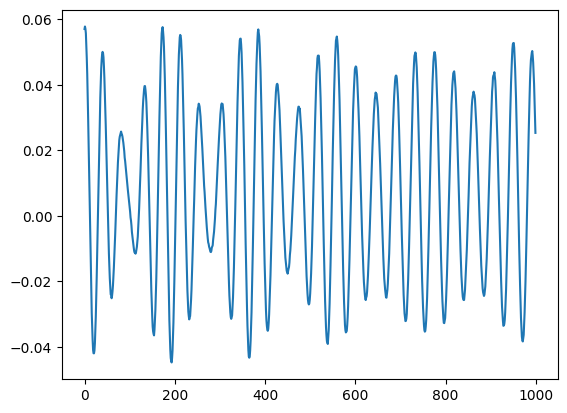

In [24]:
plt.plot(xstar.x)
plt.show()

In [25]:
xstar

          message: The maximum number of function evaluations is exceeded.
          success: False
           status: 0
              fun: 0.4024069677864479
                x: [ 5.708e-02  5.784e-02 ...  3.082e-02  2.535e-02]
              nit: 1000
             nfev: 1000
             njev: 656
             nhev: 656
         cg_niter: 4816
     cg_stop_cond: 4
             grad: [-1.418e-03  1.562e-04 ...  4.161e-04  3.633e-04]
  lagrangian_grad: [-1.418e-03  1.562e-04 ...  4.161e-04  3.633e-04]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 0.011475959038518332
 constr_violation: 0
   execution_time: 107.94629120826721
        tr_radius: 0.002880982400880797
   constr_penalty: 1.0
            niter: 1000